# CheckSymm

## Notes
- The pictures do not show the standard deviation as the number is too
  little to be pictured, being usually one or two orderd of magnitude smaller

In [1]:
# libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import re
from unum import Unum
# data
from data.data import *

# setup
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85)
# sns.set_theme(style="ticks", palette="Set2")
# Read the data
raw_data: pd.DataFrame = data.parse_data('../reports/base.txt')
raw_data_o2: pd.DataFrame = data.parse_data('../reports/opt.txt')
raw_data_o3: pd.DataFrame = data.parse_data('../reports/opt_aggressive.txt')
checkSymm_base = raw_data.loc[raw_data.name == 'checkSymm base'].copy()

# Implicit Parallelism

In [2]:
checkSymm_implicit = raw_data.loc[raw_data.name.isin(['checkSymm vectorization', 'checkSymm unrolling outer',  \
                                                      'checkSymm unrolling inner', 'checkSymm unrolling outer branchless', \
                                                      'checkSymm unrolling inner branchless'])].copy()
checkSymm_implicit_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['checkSymm vectorization', 'checkSymm unrolling outer',  \
                                                      'checkSymm unrolling inner', 'checkSymm unrolling outer branchless', \
                                                      'checkSymm unrolling inner branchless'])].copy()
checkSymm_implicit_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['checkSymm vectorization', 'checkSymm unrolling outer',  \
                                                      'checkSymm unrolling inner', 'checkSymm unrolling outer branchless', \
                                                      'checkSymm unrolling inner branchless'])].copy()

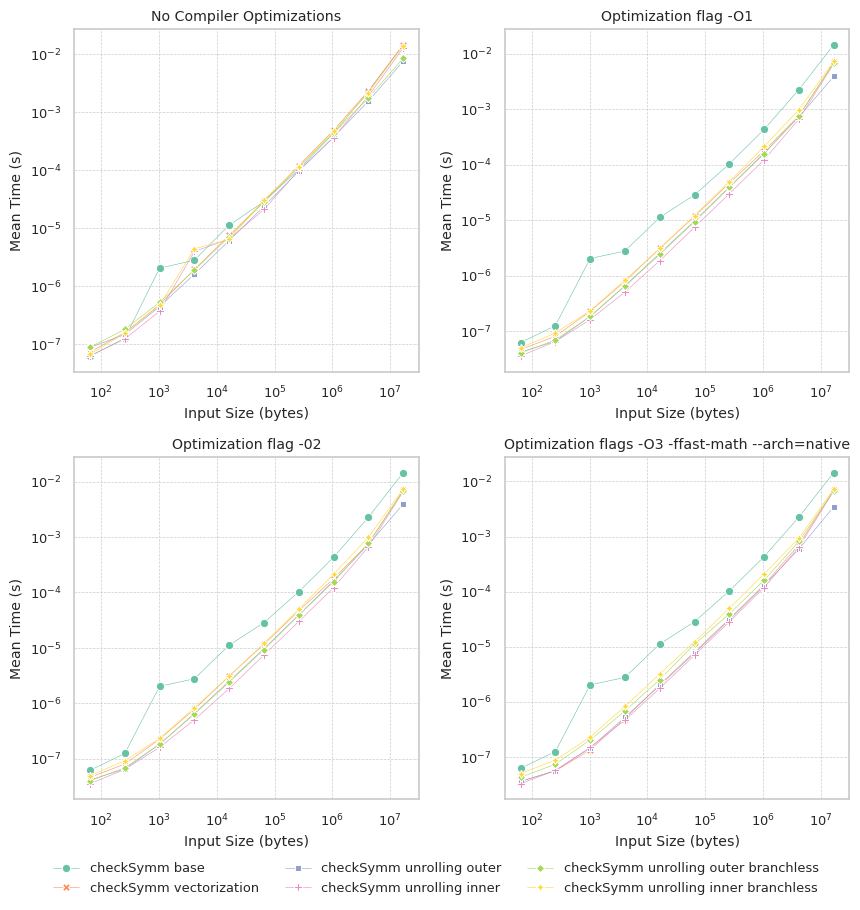

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_implicit]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0], linewidth = 0.4,
)
axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Input Size (bytes)')
axes[0][0].set_ylabel('Mean Time (s)')
axes[0,0].grid(which='major', linestyle='--', linewidth=0.5)

# TODO
lp2 = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_implicit_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 0.4,
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Input Size (bytes)')
axes[0][1].set_ylabel('Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_implicit_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 0.4
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Input Size (bytes)')
axes[1][0].set_ylabel('Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_implicit_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 0.4
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -ffast-math --arch=native')
axes[1][1].set_xlabel('Input Size (bytes)')
axes[1][1].set_ylabel('Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

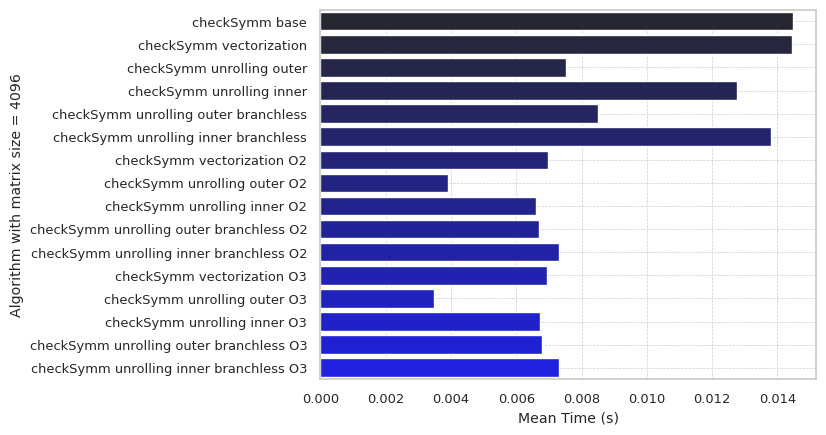

In [39]:
cs_o2 = checkSymm_implicit_o2.copy()
cs_o2['name'] = cs_o2.apply(lambda row: row['name'] + ' O2', axis=1)

cs_o3 = checkSymm_implicit_o3.copy()
cs_o3['name'] = cs_o3.apply(lambda row: row['name'] + ' O3', axis=1)

checkSymm_implicit_all = pd.concat([checkSymm_base, checkSymm_implicit, cs_o2, cs_o3])
checkSymm_implicit_cut = checkSymm_implicit_all.loc[checkSymm_implicit_all.space == 16777216]

sns.barplot(x="mean", y="name", data=checkSymm_implicit_cut, errorbar=None,
            hue='name', orient='h', palette='dark:b')
plt.ylabel('Algorithm with matrix size = 4096')
plt.xlabel('Mean Time (s)')
plt.grid(which='major', linestyle='--', linewidth=0.5)

# Explicit Parallelism

In [5]:
checkSymm_explicit_omp = raw_data.loc[raw_data.name.isin(['checkSymm omp 2','checkSymm omp 4','checkSymm omp 8', \
                                                         'checkSymm omp 16','checkSymm omp 32','checkSymm omp 64'])].copy()

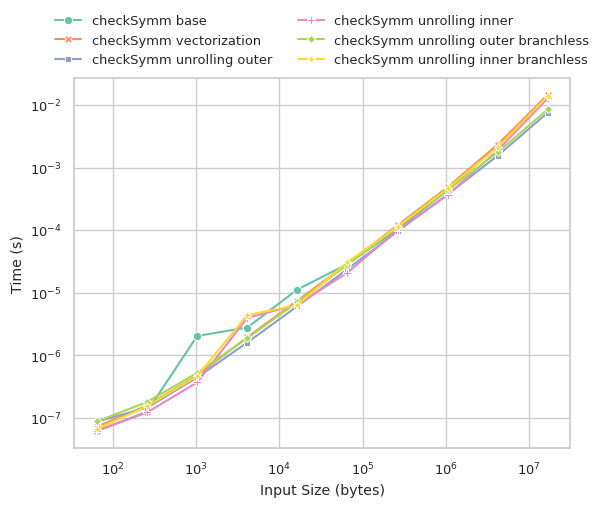

In [6]:
lp = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_implicit]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False
)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Time (s)')
sns.move_legend(
    lp, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title="", frameon=False,
)
plt.show()

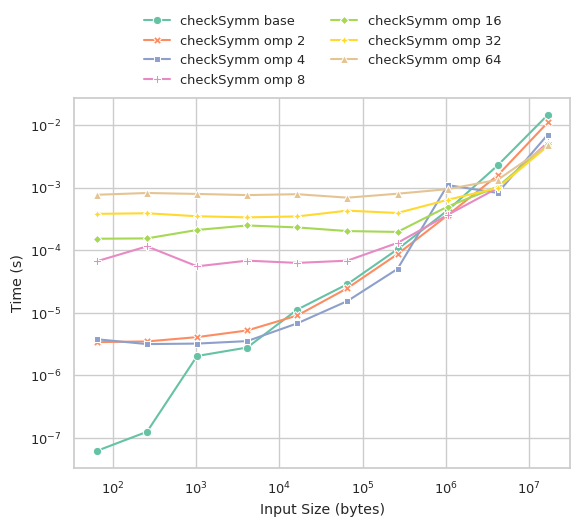

In [7]:
lp = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_explicit_omp]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False
)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Time (s)')
sns.move_legend(
    lp, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title="", frameon=False,
)
plt.show()

## Schedulers

In [8]:
checkSymm_explicit_omp_sched = raw_data.loc[raw_data.name.isin(['checkSymm omp 16 sched static','checkSymm omp 16 sched dynamic', \
                                                               'checkSymm omp 16 sched guided'])].copy()

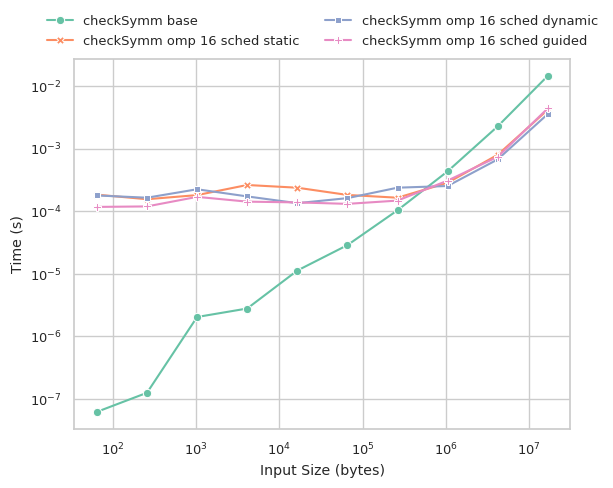

In [9]:
lp = sns.lineplot(
    data=pd.concat([checkSymm_base, checkSymm_explicit_omp_sched]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False
)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Time (s)')
sns.move_legend(
    lp, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title="", frameon=False,
)
plt.show()